In [1]:
# https://medium.com/mlearning-ai/human-segmentation-using-u-net-with-source-code-easiest-way-f78be6e238f9
import tensorflow as tf
import numpy as np
import os
from skimage.io import imread,imshow
from skimage.transform import resize
from skimage import color
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds

In [2]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256
CHANNELS = 3


training_images_names = os.listdir(r"C:\\Users\\user\\Desktop\\data\\Masks\\")
training_masks_names = os.listdir(r"C:\\Users\\user\\Desktop\\data\\Images\\")

X = np.zeros((len(training_images_names),IMG_HEIGHT,IMG_WIDTH,CHANNELS),dtype='uint8')
y = np.zeros((len(training_masks_names),IMG_HEIGHT,IMG_WIDTH,1))

In [3]:
for i,n in enumerate(training_images_names):
    img = imread(f'C:/Users/user/Desktop/data/Masks/{n}')
    img = resize(img,(IMG_HEIGHT,IMG_WIDTH,CHANNELS),mode='constant',preserve_range=True)
    fn = str(n.split('.')[0]) + '.png'
    mask = imread(f'C:/Users/user/Desktop/data/Images/{fn}')
    mask = resize(mask,(IMG_HEIGHT,IMG_WIDTH,1),mode='constant')
    
    X[i] = img
    y[i] = mask
    
X[0].shape

(256, 256, 3)

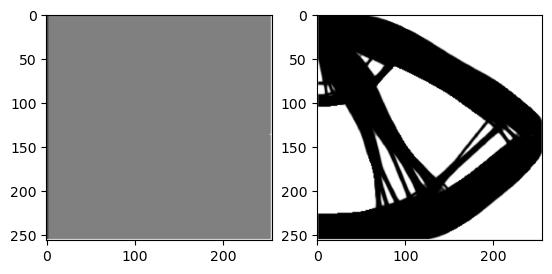

In [4]:
i = np.random.randint(0,len(X))
fig,(a1,a2)=plt.subplots(1,2)
a1.imshow(X[i])
a2.imshow(y[i].reshape(y[i].shape[:-1]),cmap='gray')

In [5]:
inputs = tf.keras.layers.Input((IMG_HEIGHT,IMG_WIDTH,CHANNELS))
s = tf.keras.layers.Lambda(lambda x:x/255)(inputs)

#contracting path
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)


c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)


c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)


c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)


c5 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5_1 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
c5_1 = tf.keras.layers.Dropout(0.3)(c5_1)
c5_2 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5_1)
c5_3 = tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_2)
c5_4 = tf.keras.layers.Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',dilation_rate=2)(c5_3 )
c5_5 = tf.keras.layers.concatenate([c5_1,c5_4])


#expanding path
u4 = tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c5_5)
u4 = tf.keras.layers.concatenate([u4,c4])
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)
u4 = tf.keras.layers.Dropout(0.2)(u4)
u4 = tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u4)


u3 = tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(u4)
u3 = tf.keras.layers.concatenate([u3,c3])
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)
u3 = tf.keras.layers.Dropout(0.2)(u3)
u3 = tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u3)


u2 = tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(u3)
u2 = tf.keras.layers.concatenate([u2,c2])
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)
u2 = tf.keras.layers.Dropout(0.2)(u2)
u2 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u2)


u1 = tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(u2)
u1 = tf.keras.layers.concatenate([u1,c1])
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)
u1 = tf.keras.layers.Dropout(0.2)(u1)
u1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u1)

output = tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(u1)

model = tf.keras.Model(inputs=[inputs],outputs=[output])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                              

                                                                                                  
 conv2d_transpose_2 (Conv2D  (None, 128, 128, 32)         8224      ['conv2d_16[0][0]']           
 Transpose)                                                                                       
                                                                                                  
 concatenate_3 (Concatenate  (None, 128, 128, 64)         0         ['conv2d_transpose_2[0][0]',  
 )                                                                   'conv2d_3[0][0]']            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 128, 128, 32)         18464     ['concatenate_3[0][0]']       
                                                                                                  
 dropout_8 (Dropout)         (None, 128, 128, 32)         0         ['conv2d_17[0][0]']           
          

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.1, random_state=42)

In [7]:
# results = model.fit(X_train,y_train,batch_size=16,epochs=100)
results = model.fit(X,y,batch_size=16,epochs=100)
model.save('models/topo_2D_non-aug_100_v1.h5')

Epoch 1/100
32/32 [==============================] - 68s 2s/step - loss: 0.7079 - accuracy: 0.3436
Epoch 2/100
32/32 [==============================] - 69s 2s/step - loss: 0.6849 - accuracy: 0.4143
Epoch 3/100
32/32 [==============================] - 67s 2s/step - loss: 0.6790 - accuracy: 0.3928
Epoch 4/100
32/32 [==============================] - 68s 2s/step - loss: 0.6546 - accuracy: 0.3361
Epoch 5/100
32/32 [==============================] - 68s 2s/step - loss: 0.6382 - accuracy: 0.3313
Epoch 6/100
32/32 [==============================] - 67s 2s/step - loss: 0.6133 - accuracy: 0.3192
Epoch 7/100
32/32 [==============================] - 69s 2s/step - loss: 0.6012 - accuracy: 0.3144
Epoch 8/100
32/32 [==============================] - 69s 2s/step - loss: 0.5913 - accuracy: 0.3169
Epoch 9/100
32/32 [==============================] - 68s 2s/step - loss: 0.5843 - accuracy: 0.3211
Epoch 10/100
32/32 [==============================] - 68s 2s/step - loss: 0.5836 - accuracy: 0.3203
Epoch 11/

32/32 [==============================] - 69s 2s/step - loss: 0.4538 - accuracy: 0.3555
Epoch 84/100
32/32 [==============================] - 68s 2s/step - loss: 0.4486 - accuracy: 0.3575
Epoch 85/100
32/32 [==============================] - 68s 2s/step - loss: 0.4474 - accuracy: 0.3579
Epoch 86/100
32/32 [==============================] - 71s 2s/step - loss: 0.4465 - accuracy: 0.3574
Epoch 87/100
32/32 [==============================] - 72s 2s/step - loss: 0.4457 - accuracy: 0.3573
Epoch 88/100
32/32 [==============================] - 72s 2s/step - loss: 0.4448 - accuracy: 0.3578
Epoch 89/100
32/32 [==============================] - 72s 2s/step - loss: 0.4445 - accuracy: 0.3573
Epoch 90/100
32/32 [==============================] - 70s 2s/step - loss: 0.4453 - accuracy: 0.3575
Epoch 91/100
32/32 [==============================] - 71s 2s/step - loss: 0.4458 - accuracy: 0.3589
Epoch 92/100
32/32 [==============================] - 70s 2s/step - loss: 0.4500 - accuracy: 0.3559
Epoch 93/100


C:\Users\user\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


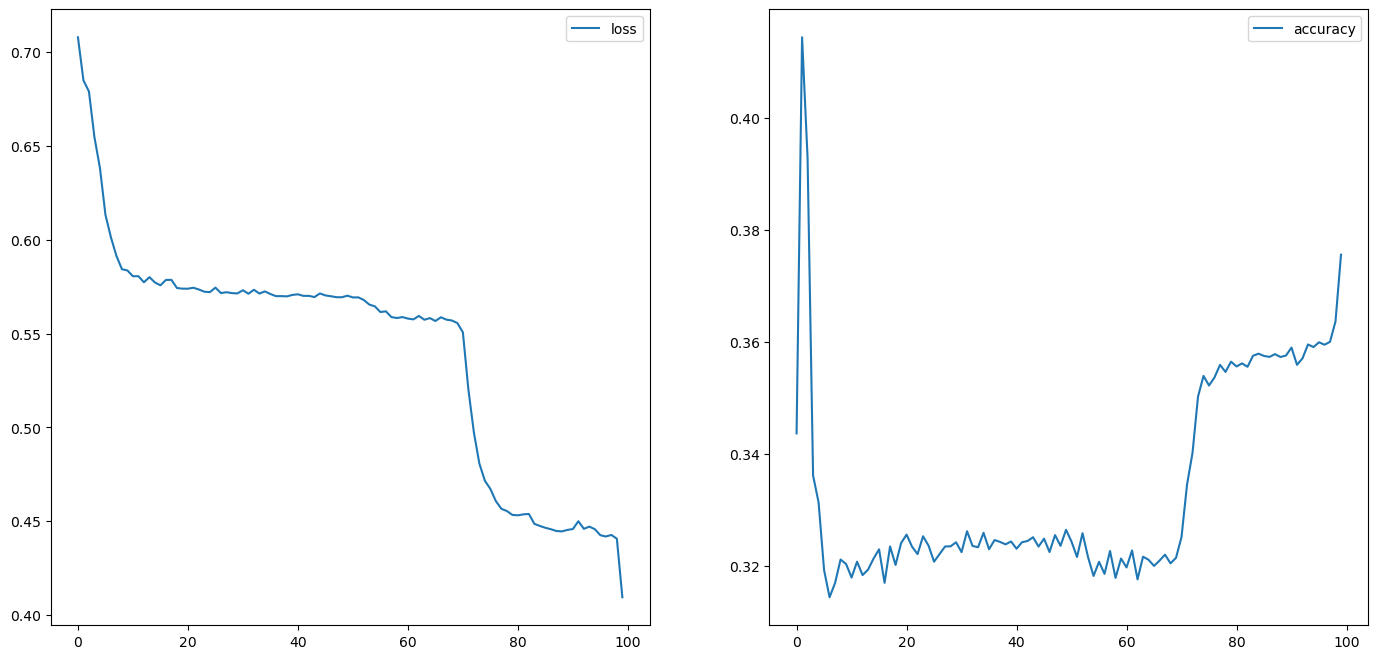

In [9]:
fig,(a1,a2) = plt.subplots(1,2,figsize=(17,8))
a1.plot(np.arange(0,100),results.history['loss'],label = 'loss')
a2.plot(np.arange(0,100),results.history['accuracy'],label='accuracy')
a1.legend()
a2.legend()
# plt.savefig('losses_and_accuracies_100_v2.png')

In [5]:
model = tf.keras.models.load_model('models/topo_segmentation_non-aug_100_v2.h5')

1/1 [==============================] - 0s 54ms/step


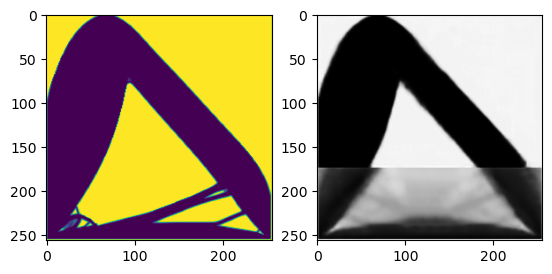

In [13]:
k=np.random.randint(0,len(X_test))
fig,(a1,a2) = plt.subplots(1,2)

a1.imshow(X_test[k])
a1.imshow(y_test[k])

(h,w,c) = X_test[k].shape
i = X_test[k].reshape((1,h,w,c))

pred = model.predict(i)

a2.imshow(pred.reshape(pred.shape[1:-1]),cmap='gray')

In [11]:
mse = []
for i in range(0,pred.shape[1]):
    mse.append(sum((pred[0,i]-X_test[0,i])**2)/len(pred[0,i]))
SSE = sum(mse)/len(mse)
print("SSE=",SSE)

SST = []
for i in range(0,pred.shape[1]):
    SST.append(sum((sum(X_test[0,i])/len(X_test[0,i])-X_test[0,i])**2)/len(pred[0,i]))
SST = sum(SST)/len(SST)
print("SST=",SST)

R_squared = 1 - SSE/SST
print("R_squared = ",R_squared)

SSE= [16834.676 16834.676 16834.676]
SST= [16799.33211106 16799.33211106 16799.33211106]
R_squared =  [-0.00210387 -0.00210387 -0.00210387]


In [26]:
print(X_test)

[[[[223 223 223]
   [226 226 226]
   [227 227 227]
   ...
   [230 230 230]
   [232 232 232]
   [223 223 223]]

  [[232 232 232]
   [ 85  85  85]
   [104 104 104]
   ...
   [139 139 139]
   [168 168 168]
   [235 235 235]]

  [[231 231 231]
   [ 65  65  65]
   [ 89  89  89]
   ...
   [128 128 128]
   [160 160 160]
   [234 234 234]]

  ...

  [[231 231 231]
   [ 65  65  65]
   [ 89  89  89]
   ...
   [128 128 128]
   [160 160 160]
   [234 234 234]]

  [[232 232 232]
   [ 85  85  85]
   [104 104 104]
   ...
   [139 139 139]
   [168 168 168]
   [235 235 235]]

  [[223 223 223]
   [226 226 226]
   [227 227 227]
   ...
   [230 230 230]
   [232 232 232]
   [223 223 223]]]


 [[[223 223 223]
   [232 232 232]
   [230 230 230]
   ...
   [230 230 230]
   [232 232 232]
   [223 223 223]]

  [[235 235 235]
   [170 170 170]
   [139 139 139]
   ...
   [139 139 139]
   [168 168 168]
   [235 235 235]]

  [[234 234 234]
   [160 160 160]
   [128 128 128]
   ...
   [128 128 128]
   [160 160 160]
   [234 234

In [27]:
print(pred)

[[[[0.8142413 ]
   [0.8199892 ]
   [0.8184484 ]
   ...
   [0.7992016 ]
   [0.8083419 ]
   [0.7648752 ]]

  [[0.8219434 ]
   [0.8493312 ]
   [0.84908843]
   ...
   [0.85868186]
   [0.8445761 ]
   [0.8044129 ]]

  [[0.80383694]
   [0.83425367]
   [0.8339929 ]
   ...
   [0.83431953]
   [0.84038025]
   [0.8105452 ]]

  ...

  [[0.7949858 ]
   [0.26910922]
   [0.05671186]
   ...
   [0.0455604 ]
   [0.1744387 ]
   [0.73355997]]

  [[0.75711834]
   [0.35444582]
   [0.15106317]
   ...
   [0.12923905]
   [0.28922653]
   [0.7775294 ]]

  [[0.7706367 ]
   [0.7834646 ]
   [0.762561  ]
   ...
   [0.7523323 ]
   [0.730516  ]
   [0.8309606 ]]]]
